# Artificial Neural Network

This notebook was created by Camille-Amaury JUGE, in order to better understand ANN principles and how they work.

(it follows the exercices proposed by Hadelin de Ponteves on Udemy : https://www.udemy.com/course/le-deep-learning-de-a-a-z/)

## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# scikit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
# keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


## Dataset

The dataset deals with banking customer's account, with several information on each individuals. The major problem to explore is that some of the customers are leaving the bank for some reasons that we don't know. 

Our aim is then to find profile(s) which match the leaving conditions and find a solution to keep the customers matching.

In [3]:
df = pd.read_csv("Churn_Modelling.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Firstly, we see that we only have categorical or continuous data. This will be easy do deal with by using sklearn encoders.
Nextly, we want to check the different distribution of the dataset.

In [4]:
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [5]:
df.describe().transpose().round()

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5000.0,2887.0,1.0,2501.0,5000.0,7500.0,10000.0
CustomerId,10000.0,15690941.0,71936.0,15565701.0,15628528.0,15690738.0,15753234.0,15815690.0
CreditScore,10000.0,651.0,97.0,350.0,584.0,652.0,718.0,850.0
Age,10000.0,39.0,10.0,18.0,32.0,37.0,44.0,92.0
Tenure,10000.0,5.0,3.0,0.0,3.0,5.0,7.0,10.0
Balance,10000.0,76486.0,62397.0,0.0,0.0,97199.0,127644.0,250898.0
NumOfProducts,10000.0,2.0,1.0,1.0,1.0,1.0,2.0,4.0
HasCrCard,10000.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
IsActiveMember,10000.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
EstimatedSalary,10000.0,100090.0,57510.0,12.0,51002.0,100194.0,149388.0,199992.0


Here we can clearly see that :
* The percentage of people who leaved is lower than 25% (which is quite comforting).
* The distribution over the credit score is balanced (mean ~ median).
* The distribution over the Balance is going lower meaning that there are more outliers with little of money (mean < median).
* The distribution over the estimated Salary seems quite balanced too.
* The overall age is also balanced between younger and older people (which may earns more) around 37 years old for the median

In [6]:
pd.DataFrame(df["Geography"].value_counts().transpose())

,Geography
France,5014
Germany,2509
Spain,2477


Here, we can see that the Bank has collected the double of information in France than in Germany and Spain. Then the network could perform better on the France's customers.

In [7]:
pd.DataFrame(df["Gender"].value_counts().transpose())

,Gender
Male,5457
Female,4543


Then, the gender distribution is quite balanced, there is just less women.

## Pre-Processing

We will now convert categorical variables for the network, and also deal with useless variable such as id, name ...

In [8]:
df_train = df.loc[:,df.columns[3:]]
df_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [9]:
def label_encoder_converting(x):
    label_encoder = LabelEncoder()
    return label_encoder.fit_transform(x)

In [10]:
df_train["Gender"] = label_encoder_converting(df_train["Gender"])
df_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,0,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0
2,502,France,0,42,8,159660.80,3,1,0,113931.57,1
3,699,France,0,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0


In [11]:
def one_hot_encoder_converting(x):
    one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
    return one_hot_encoder.fit_transform(x).toarray()

In [12]:
geo_df = pd.DataFrame(one_hot_encoder_converting(df_train[["Geography"]]))
geo_df.head()

,0,1,2
0,1.0,0.0,0.0
1,0.0,0.0,1.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,0.0,0.0,1.0


Since we only have three values (following binary theory) and we have three columns, we will delete one which is useless.

In [13]:
geo_df = geo_df.drop(labels=[0], axis=1)
df_train = df_train.drop(labels=["Geography"], axis=1)
df_train = pd.concat([df_train, geo_df], axis=1)
df_train.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,1,2
0,619,0,42,2,0.00,1,1,1,101348.88,1,0.0,0.0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0.0,1.0
2,502,0,42,8,159660.80,3,1,0,113931.57,1,0.0,0.0
3,699,0,39,1,0.00,2,0,0,93826.63,0,0.0,0.0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0.0,1.0


In [14]:
y = df_train["Exited"]
X = df_train.drop(labels=["Exited"], axis=1)

We will now scale every values to help the network

In [15]:
std_scaler = StandardScaler()
X = pd.DataFrame(std_scaler.fit_transform(X))
X.head()

,0,1,2,3,4,5,6,7,8,9,10
0,-0.326221,-1.095988,0.293517,-1.041760,-1.225848,-0.911583,0.646092,0.970243,0.021886,-0.578736,-0.573809
1,-0.440036,-1.095988,0.198164,-1.387538,0.117350,-0.911583,-1.547768,0.970243,0.216534,-0.578736,1.742740
2,-1.536794,-1.095988,0.293517,1.032908,1.333053,2.527057,0.646092,-1.030670,0.240687,-0.578736,-0.573809
3,0.501521,-1.095988,0.007457,-1.387538,-1.225848,0.807737,-1.547768,-1.030670,-0.108918,-0.578736,-0.573809
4,2.063884,-1.095988,0.388871,-1.041760,0.785728,-0.911583,0.646092,0.970243,-0.365276,-0.578736,1.742740


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Model creation

In [17]:
def create_labels(labels, length):
    x_labels = []
    for i in range(length):
        x_labels.append("Predicted {}".format(labels[i]))
    y_labels = []
    for i in range(length):
        y_labels.append("Is {}".format(labels[i]))
    return (x_labels, y_labels)

def heatmap_numbers(m, labels, title):
    lenght = len(labels)
    
    # Creating plot base config
    fig, ax = plt.subplots(figsize=(16,10))
    im = ax.imshow(m, cmap="copper")
    
    # Creating labels
    (x_axis_labels, y_axis_labels) = create_labels(labels, lenght)

    # Positionning Labels on axis
    ax.set_xticks(np.arange(lenght))
    ax.set_xticklabels(x_axis_labels)
    ax.set_yticks(np.arange(lenght))
    ax.set_yticklabels(y_axis_labels)
    ax.grid(False)

    # Rotate labels on x axis
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Put values in each case
    for i in range(lenght):
        for j in range(lenght):
            text = ax.text(j, i, m[i, j], ha="center", va="center", color="red", fontsize="large")

    ax.set_title(title)
    fig.tight_layout()
    plt.show()

### Simple Hidden Layer

In [18]:
# model creation
clf_model_1 = Sequential()
# Input layer and first Hidden Layer
clf_model_1.add(Dense(units=6, activation="relu", 
                      kernel_initializer="uniform", 
                      input_dim=X_train.shape[1]))
# OutputLayer
clf_model_1.add(Dense(units=1, activation="sigmoid", 
                      kernel_initializer="uniform"))
clf_model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 79
Trainable params: 79
Non-trainable params: 0
_________________________________________________________________


In [19]:
clf_model_1.compile(optimizer="adam", loss="binary_crossentropy", 
                    metrics=["accuracy"])
clf_model_1.fit(X_train, y_train, validation_split=0.1, epochs=100)

Train on 6750 samples, validate on 750 samples
Epoch 1/100
6750/6750 [==============================] - 0s 55us/step - loss: 0.6148 - accuracy: 0.7923 - val_loss: 0.5089 - val_accuracy: 0.7987
Epoch 2/100
6750/6750 [==============================] - 0s 36us/step - loss: 0.4572 - accuracy: 0.7945 - val_loss: 0.4351 - val_accuracy: 0.7987
Epoch 3/100
6750/6750 [==============================] - 0s 36us/step - loss: 0.4310 - accuracy: 0.7945 - val_loss: 0.4293 - val_accuracy: 0.7987
Epoch 4/100
6750/6750 [==============================] - 0s 35us/step - loss: 0.4276 - accuracy: 0.7945 - val_loss: 0.4269 - val_accuracy: 0.7987
Epoch 5/100
6750/6750 [==============================] - 0s 36us/step - loss: 0.4258 - accuracy: 0.7945 - val_loss: 0.4253 - val_accuracy: 0.7987
Epoch 6/100
6750/6750 [==============================] - 0s 36us/step - loss: 0.4244 - accuracy: 0.7945 - val_loss: 0.4249 - val_accuracy: 0.7987
Epoch 7/100
6750/6750 [==============================] - 0s 37us/step - loss:

In [20]:
seuil = 0.5
y_pred = (clf_model_1.predict(X_test) > seuil)
cf_matrix = confusion_matrix(y_test, y_pred)

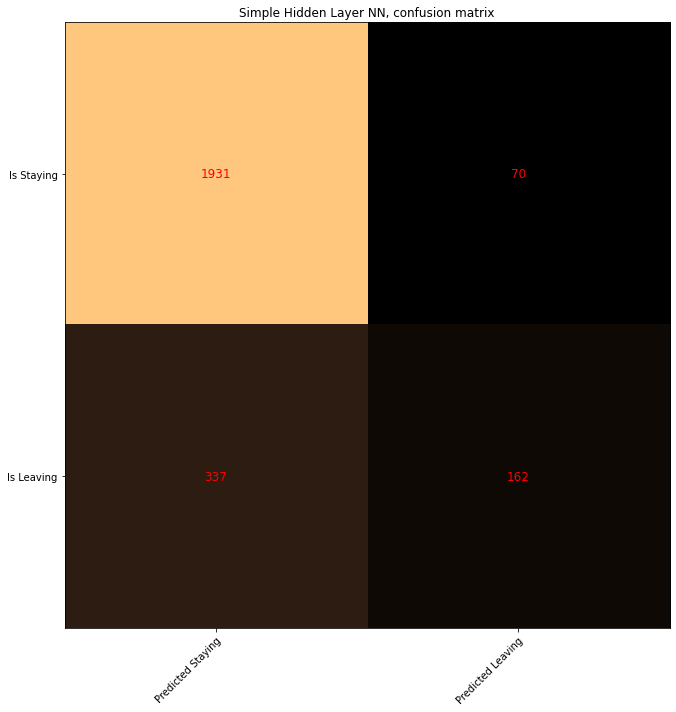

In [21]:
heatmap_numbers(cf_matrix, ["Staying", "Leaving"], "Simple Hidden Layer NN, confusion matrix")

In [22]:
print("Accuracy on test set : {}".format(accuracy_score(y_test, y_pred)))

Accuracy on test set : 0.8372


## Two Hidden Layer

In [23]:
clf_model_2 = Sequential()
clf_model_2.add(Dense(units=6, activation="relu", 
                      kernel_initializer="uniform", 
                      input_dim=X_train.shape[1]))
clf_model_2.add(Dense(units=3, activation="relu", 
                      kernel_initializer="uniform"))
clf_model_2.add(Dense(units=1, activation="sigmoid", 
                      kernel_initializer="uniform"))
clf_model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 6)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 21        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 4         
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


In [24]:
clf_model_2.compile(optimizer="adam", loss="binary_crossentropy", 
                    metrics=["accuracy"])
clf_model_2.fit(X_train.values, y_train, validation_split=0.1, epochs=100)

Train on 6750 samples, validate on 750 samples
Epoch 1/100
6750/6750 [==============================] - 0s 61us/step - loss: 0.5967 - accuracy: 0.7945 - val_loss: 0.4622 - val_accuracy: 0.7987
Epoch 2/100
6750/6750 [==============================] - 0s 40us/step - loss: 0.4407 - accuracy: 0.7945 - val_loss: 0.4323 - val_accuracy: 0.7987
Epoch 3/100
6750/6750 [==============================] - 0s 39us/step - loss: 0.4318 - accuracy: 0.7945 - val_loss: 0.4287 - val_accuracy: 0.7987
Epoch 4/100
6750/6750 [==============================] - 0s 40us/step - loss: 0.4283 - accuracy: 0.7945 - val_loss: 0.4260 - val_accuracy: 0.7987
Epoch 5/100
6750/6750 [==============================] - 0s 39us/step - loss: 0.4256 - accuracy: 0.7945 - val_loss: 0.4234 - val_accuracy: 0.7987
Epoch 6/100
6750/6750 [==============================] - 0s 40us/step - loss: 0.4234 - accuracy: 0.7945 - val_loss: 0.4213 - val_accuracy: 0.7987
Epoch 7/100
6750/6750 [==============================] - 0s 40us/step - loss:

In [25]:
seuil = 0.5
y_pred = (clf_model_2.predict(X_test) > seuil)
cf_matrix = confusion_matrix(y_test, y_pred)

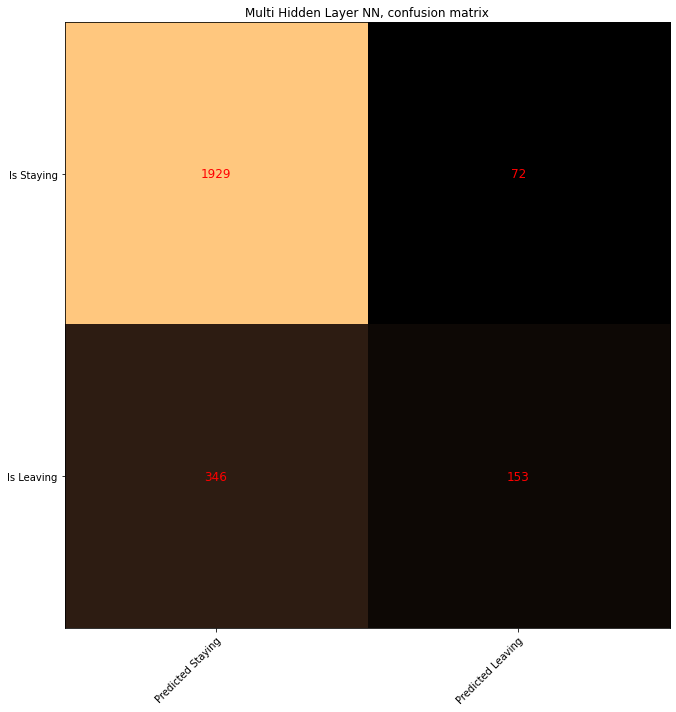

In [26]:
heatmap_numbers(cf_matrix, ["Staying", "Leaving"], "Multi Hidden Layer NN, confusion matrix")

In [27]:
print("Accuracy on test set : {}".format(accuracy_score(y_test, y_pred)))

Accuracy on test set : 0.8328


## Two Hidden Layer Increased


In [28]:
clf_model_3 = Sequential()
clf_model_3.add(Dense(units=10, activation="relu", 
                      kernel_initializer="uniform", 
                      input_dim=X_train.shape[1]))
clf_model_3.add(Dense(units=6, activation="relu", 
                      kernel_initializer="uniform"))
clf_model_3.add(Dense(units=1, activation="sigmoid", 
                      kernel_initializer="uniform"))
clf_model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 10)                120       
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 66        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 7         
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [29]:
clf_model_3.compile(optimizer="adam", loss="binary_crossentropy", 
                    metrics=["accuracy"])
clf_model_3.fit(X_train.values, y_train, validation_split=0.1, epochs=100)

Train on 6750 samples, validate on 750 samples
Epoch 1/100
6750/6750 [==============================] - 0s 61us/step - loss: 0.5757 - accuracy: 0.7942 - val_loss: 0.4379 - val_accuracy: 0.7987
Epoch 2/100
6750/6750 [==============================] - 0s 40us/step - loss: 0.4324 - accuracy: 0.7945 - val_loss: 0.4246 - val_accuracy: 0.7987
Epoch 3/100
6750/6750 [==============================] - 0s 40us/step - loss: 0.4246 - accuracy: 0.7945 - val_loss: 0.4233 - val_accuracy: 0.7987
Epoch 4/100
6750/6750 [==============================] - 0s 40us/step - loss: 0.4195 - accuracy: 0.7945 - val_loss: 0.4191 - val_accuracy: 0.7987
Epoch 5/100
6750/6750 [==============================] - 0s 39us/step - loss: 0.4146 - accuracy: 0.7945 - val_loss: 0.4143 - val_accuracy: 0.7987
Epoch 6/100
6750/6750 [==============================] - 0s 39us/step - loss: 0.4098 - accuracy: 0.7945 - val_loss: 0.4108 - val_accuracy: 0.7987
Epoch 7/100
6750/6750 [==============================] - 0s 42us/step - loss:

In [30]:
seuil = 0.5
y_pred = (clf_model_3.predict(X_test) > seuil)
cf_matrix = confusion_matrix(y_test, y_pred)

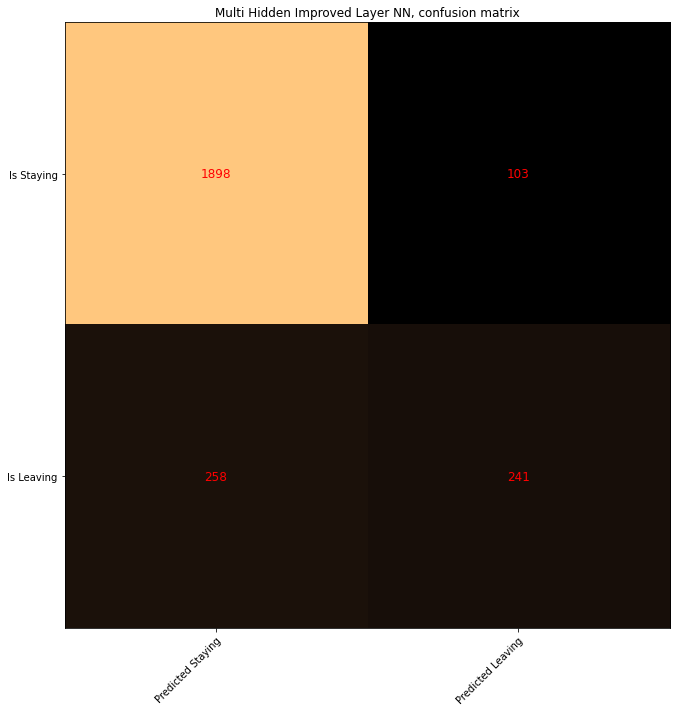

In [31]:
heatmap_numbers(cf_matrix, ["Staying", "Leaving"], "Multi Hidden Improved Layer NN, confusion matrix")

In [32]:
print("Accuracy on test set : {}".format(accuracy_score(y_test, y_pred)))

Accuracy on test set : 0.8556


## Cross Validation

Now that we have done some basic neural networks tests, we are going to try a more advanced method which is cross validation (K-Fold).

We seek for a low variance(regularity in training) and a low biais (good accuracy)

In [33]:
def build_classifier():
    clf_model = Sequential()
    clf_model.add(Dense(units=10, activation="relu", 
                          kernel_initializer="uniform", 
                          input_dim=X_train.shape[1]))
    clf_model.add(Dense(units=6, activation="relu", 
                          kernel_initializer="uniform"))
    clf_model.add(Dense(units=1, activation="sigmoid", 
                          kernel_initializer="uniform"))
    clf_model.summary()
    clf_model.compile(optimizer="adam", loss="binary_crossentropy", 
                    metrics=["accuracy"])
    return clf_model

In [34]:
clf_1 = KerasClassifier(build_fn=build_classifier)

In [35]:
k_fold_scores = cross_val_score(clf_1, X=X_train, y=y_train, cv=10, 
                                 verbose=4, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    6.5s remaining:    9.8s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    8.2s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.3s finished


In [36]:
k_fold_scores.mean().round(3)

0.795

In [37]:
k_fold_scores.std().round(3)

0.015

## Dropout

We will explore here a way to counterbalance overfitting called dropout

In [38]:
clf_model = Sequential()
clf_model.add(Dense(units=10, activation="relu", 
                          kernel_initializer="uniform", 
                          input_dim=X_train.shape[1]))
clf_model.add(Dropout(rate=0.1))
clf_model.add(Dense(units=6, activation="relu", 
                          kernel_initializer="uniform"))
clf_model.add(Dropout(rate=0.1))
clf_model.add(Dense(units=1, activation="sigmoid", 
                          kernel_initializer="uniform"))
clf_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 10)                120       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 66        
_________________________________________________________________
dropout_2 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 7         
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


## Improve by increasing hyperparameters

Using gridsearch or randomsearch to optimize

In [44]:
def build_classifier(input_dim, layers_nb, function, kernel_init, optimizer):
    clf_model = Sequential()
    layers_nb = layers_nb.split("-")
    for i in range(len(layers_nb)):
        if i == 0:
            clf_model.add(Dense(units=int(layers_nb[i]), activation="relu", 
                          kernel_initializer=kernel_init, 
                          input_dim=input_dim))
        elif i == len(layers_nb) - 1:
            clf_model.add(Dense(units=int(layers_nb[i]), activation=function, 
                          kernel_initializer=kernel_init))
        else:
            clf_model.add(Dense(units=int(layers_nb[i]), activation="relu", 
                          kernel_initializer=kernel_init))
    clf_model.compile(optimizer=optimizer, loss="binary_crossentropy", 
                    metrics=["accuracy"])
    return clf_model

In [49]:
layer_nb = []
for i in range(3,11):
    # single-layer
    layer_nb.append("{}-1".format(i))
    # multi-layer
    for j in range(2,i+1):
        layer_nb.append("{}-{}-1".format(i,j))

params = {
    "epochs": range(20,101,20),
    "optimizer":["adam", "rmsprop"],
    "function":["sigmoid"],
    "kernel_init":["uniform"],
    "input_dim":[X_train.shape[1]],
    "layers_nb":layer_nb
}
clf_1 = KerasClassifier(build_fn=build_classifier)
rs_cv = RandomizedSearchCV(estimator=clf_1, param_distributions=params, 
                           scoring="accuracy", cv=10, verbose=1, n_jobs=-1)

In [50]:
rs_cv = rs_cv.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.1min finished


Epoch 1/40
7500/7500 [==============================] - 0s 51us/step - loss: 0.6598 - accuracy: 0.7933
Epoch 2/40
7500/7500 [==============================] - 0s 34us/step - loss: 0.6068 - accuracy: 0.7949
Epoch 3/40
7500/7500 [==============================] - 0s 35us/step - loss: 0.5637 - accuracy: 0.7949
Epoch 4/40
7500/7500 [==============================] - 0s 34us/step - loss: 0.5259 - accuracy: 0.7951
Epoch 5/40
7500/7500 [==============================] - 0s 34us/step - loss: 0.4922 - accuracy: 0.8131
Epoch 6/40
7500/7500 [==============================] - 0s 35us/step - loss: 0.4653 - accuracy: 0.8256
Epoch 7/40
7500/7500 [==============================] - 0s 35us/step - loss: 0.4465 - accuracy: 0.8315
Epoch 8/40
7500/7500 [==============================] - 0s 35us/step - loss: 0.4344 - accuracy: 0.8325
Epoch 9/40
7500/7500 [==============================] - 0s 34us/step - loss: 0.4272 - accuracy: 0.8349
Epoch 10/40
7500/7500 [==============================] - 0s 35us/step - l

In [51]:
rs_cv.best_params_

{'optimizer': 'rmsprop',
 'layers_nb': '10-2-1',
 'kernel_init': 'uniform',
 'input_dim': 11,
 'function': 'sigmoid',
 'epochs': 40}

In [52]:
rs_cv.best_score_

0.8492

We reached a best score of 0.85 using the previous parameters.